In [1]:
import os
import pathlib
import pandas as pd
from sklearn.metrics import classification_report
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID";
os.environ["CUDA_VISIBLE_DEVICES"]="0"; 

In [2]:
!pip install ktrain
import ktrain
from ktrain import text

     |████████████████████████████████| 25.2 MB 4.1 MB/s 
     |████████████████████████████████| 981 kB 36.3 MB/s 
     |████████████████████████████████| 241 kB 41.8 MB/s 
     |████████████████████████████████| 3.3 MB 45.5 MB/s 
     |████████████████████████████████| 468 kB 42.9 MB/s 
  Created wheel for ktrain: filename=ktrain-0.14.7-py3-none-any.whl size=25240972 sha256=331deec1691521d8c5f7b188456d5533d72341c0785f141326b0ea55ad8cb760
  Stored in directory: /root/.cache/pip/wheels/d5/f8/64/c482e2e11303d04d85af01b9b94ecfbeff8620be8f6e543e5f
  Created wheel for keras-bert: filename=keras_bert-0.81.0-py3-none-any.whl size=37912 sha256=56937c3b5979dacccfac4a51ee57b34c2f9be1a5d4f4c76d83c8dc4c55566ba2
  Stored in directory: /root/.cache/pip/wheels/fc/f6/94/9c54242cde921a3cdc7d049bae3f137d21fa28d3b8ccefd8a0
  Created wheel for langdetect: filename=langdetect-1.0.8-py3-none-any.whl size=993191 sha256=a446e42a047413a4adbf904babf23e167d1da2b70ce36d7deb446407c10dc60a
  Stored in directory: /

In [3]:
#check if the paths for the input data is valid.
train_path="../input/sentimentdatasets/trainGithub.csv"
test_path="../input/sentimentdatasets/testGithub.csv"
tr_path= pathlib.Path(train_path)
te_path=pathlib.Path(test_path)
if tr_path.exists ():
    print("Train data path set.")
else: 
    raise SystemExit("Train data path does not exist.")
     
if te_path.exists ():
    print("Test data path set.")
else: 
    raise SystemExit("Test data path does not exist.")
     

Train data path set.
Test data path set.


In [4]:
#showing the first 5 lines of the train data
train_df=pd.read_csv(train_path, sep=';', header=0)
train_df.head()


,ID,Polarity,Text
0,1534416,negative,your don't understand me :( see https://github...
1,508287,neutral,John pointed out that the keySet is a mutable ...
2,945853,neutral,"Don't forget to rerun cmake, guys."""
3,1036479,positive,"kandera, congratulate to join team!!!!"""
4,1299920,neutral,I have uploaded the libgcrypt-1.4.5.tar.bz2 to...


In [5]:
#showing the first 5 lines of the test data
test_df=pd.read_csv(test_path, sep=';', header=0)
test_df.head()

,ID,Polarity,Text
0,284853,positive,Thanks! Fixed. You think after all those code ...
1,45017,negative,"Aw, such a shame..."""
2,404962,positive,"Sorry for my last comment vcrx6, thanks for yo..."
3,4185263,neutral,Yes. eg. above `pam['gecos_map'']` is passed t...
4,21077,negative,"sorry, but I don't understand you :/"""


In [6]:
(x_train, y_train), (x_test, y_test), preproc =  text.texts_from_array(train_df["Text"], train_df["Polarity"],  x_test=test_df["Text"], y_test=test_df["Polarity"], 
                                                                     maxlen=500, preprocess_mode='bert')
                                                                     
                  

task: text regression (supply class_names argument if this is supposed to be classification task)
downloading pretrained BERT model (uncased_L-12_H-768_A-12.zip)...
[██████████████████████████████████████████████████]
extracting pretrained BERT model...
done.

cleanup downloaded zip...
done.

preprocessing train...
language: en


preprocessing test...
language: en


In [7]:
model = text.text_classifier('bert', (x_train, y_train) , preproc=preproc)

Is Multi-Label? False
maxlen is 500
done.


In [8]:
learner = ktrain.get_learner(model, 
                             train_data=(x_train, y_train), 
                             val_data=(x_test, y_test), 
                             batch_size=6)

In [9]:
learner.lr_find()

simulating training for different learning rates... this may take a few moments...
Train on 4985 samples
Epoch 1/1024
4985/4985 [==============================] - 700s 140ms/sample - loss: 0.8268 - accuracy: 0.6066
Epoch 2/1024
1686/4985 [=========>....................] - ETA: 7:26 - loss: 1.4093 - accuracy: 0.3464

done.
Please invoke the Learner.lr_plot() method to visually inspect the loss plot to help identify the maximal learning rate associated with falling loss.


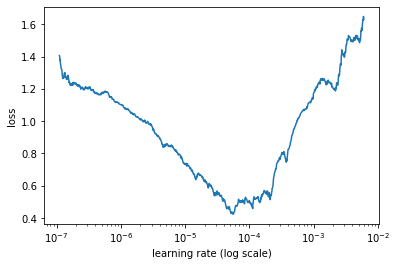

In [10]:
learner.lr_plot()

In [11]:
# 2e-5 is one of the LRs  recommended by Google and is consistent with the plot above.
learner.autofit(2e-5, early_stopping=5)

reduce_on_plateau automatically enabled at patience=2


begin training using triangular learning rate policy with max lr of 2e-05...
Train on 4985 samples, validate on 2137 samples
Epoch 1/1024
4985/4985 [==============================] - 749s 150ms/sample - loss: 0.4987 - accuracy: 0.7930 - val_loss: 0.2520 - val_accuracy: 0.9111
Epoch 2/1024
4985/4985 [==============================] - 731s 147ms/sample - loss: 0.1768 - accuracy: 0.9416 - val_loss: 0.2570 - val_accuracy: 0.9073
Epoch 3/1024
4980/4985 [============================>.] - ETA: 0s - loss: 0.0953 - accuracy: 0.9707
Epoch 00003: Reducing Max LR on Plateau: new max lr will be 1e-05 (if not early_stopping).
4985/4985 [==============================] - 742s 149ms/sample - loss: 0.0957 - accuracy: 0.9705 - val_loss: 0.2602 - val_accuracy: 0.9144
Epoch 4/1024
4985/4985 [==============================] - 758s 152ms/sample - loss: 0.0400 - accuracy: 0.9884 - val_loss: 0.3289 - val_accuracy: 0.9162
Epoch 5/1024
4980/4985 [=========

In [12]:
model.save("github_model.h5")

In [13]:
predictor = ktrain.get_predictor(learner.model, preproc)

In [14]:
data=test_df["Text"].tolist()
label=test_df["Polarity"].tolist()

In [15]:
i=0
correct=0
wrong=0
total=len(data)
true_lab=[]
pred_lab=[]
text=[]
for dt in data:
    result=predictor.predict(dt)
    if not result== label[i]:
        text.append(dt)
        pred_lab.append(result)
        true_lab.append(label[i])
        wrong+=1
    else:
        correct+=1
    
    i+=1

name_dict = {
            'Name': text,
            'Gold Label' : true_lab,
            'Predicted Label': pred_lab
          }

wrong_data= pd.DataFrame(name_dict)

wrong_data.to_csv("wrong_results.csv", sep=';')   
    
    

In [16]:
names = ['negative', 'neutral', 'positive']
y_pred = predictor.predict(data)
y_true= test_df["Polarity"]
print(classification_report(y_true, y_pred, target_names=names))

              precision    recall  f1-score   support

    negative       0.88      0.93      0.91       626
     neutral       0.93      0.90      0.91       907
    positive       0.92      0.91      0.91       604

    accuracy                           0.91      2137
   macro avg       0.91      0.91      0.91      2137
weighted avg       0.91      0.91      0.91      2137



In [17]:
print("Correct: ", correct,"/",total,"\nWrong: ", wrong,"/",total)

Correct:  1947 / 2137 
Wrong:  190 / 2137
